# 1. Data Colection

### Import necessary Library

In [ ]:
# 1. Import Library
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

df = pd.read_parquet("../dataset/NF_BoT_IoT_V2/NF-BoT-IoT-V2.parquet", engine="pyarrow")  # or engine="fastparquet"
# View the first few rows
df.head()

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

df = df.sample(frac=0.01, random_state=42)
print(f"Sampled dataset shape: {df.shape}")
#2. Handling Missing variable
# Handle missing values: fill numerical with mean, others with 0
for col in df.columns:
    
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(0)
df.isna().sum()

#3. Data Encoding
# Encode categorical features (PROTOCOL, L7_PROTO)
le_protocol = LabelEncoder()
df['PROTOCOL'] = le_protocol.fit_transform(df['PROTOCOL'].astype(str))
le_l7_proto = LabelEncoder()
df['L7_PROTO'] = le_l7_proto.fit_transform(df['L7_PROTO'].astype(str))

#4.  Binary Classfication
# Extract labels for binary classification (Label: 0=benign, 1=attack)
y = df['Label'].values

# 4.1 Feature Selection and Normalization
# Select numerical features (exclude Label, Attack)
feature_cols = [col for col in df.columns if col not in ['Label', 'Attack']]
X = df[feature_cols].values

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 4.2. Data Preprocessing
# Create preprocessed DataFrame
df_processed = pd.DataFrame(X, columns=feature_cols)
df_processed['Label'] = y
df_processed['L4_SRC_PORT'] = df['L4_SRC_PORT'].values  # Retain for graph
df_processed['L4_DST_PORT'] = df['L4_DST_PORT'].values
print(f"Preprocessed dataset shape: {df_processed.shape}")

# 4.3. Graph Construction
# === Graph Construction ===
# Map unique ports to node indices
src_ports = df_processed['L4_SRC_PORT'].values
dst_ports = df_processed['L4_DST_PORT'].values
unique_ports = np.unique(np.concatenate([src_ports, dst_ports]))
port_to_idx = {port: idx for idx, port in enumerate(unique_ports)}

# Aggregate node features and labels
node_features = defaultdict(list)
node_labels = defaultdict(list)
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_port = row['L4_SRC_PORT']
    dst_port = row['L4_DST_PORT']
    features = row.drop(['Label', 'L4_SRC_PORT', 'L4_DST_PORT']).values
    label = row['Label']
    node_features[port_to_idx[src_port]].append(features[:-1])  # Exclude label
    node_features[port_to_idx[dst_port]].append(features[:-1])
    node_labels[port_to_idx[src_port]].append(label)
    node_labels[port_to_idx[dst_port]].append(label)

# Compute average features and labels per node
x = []
y = []
for port_idx in range(len(unique_ports)):
    if port_idx in node_features:
        x.append(np.mean(node_features[port_idx], axis=0))
        y.append(np.mean(node_labels[port_idx]))  # Majority for binary
    else:
        x.append(np.zeros(df_processed.shape[1] - 3))  # Default features
        y.append(0)  # Default label

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Construct edges (bidirectional)
edge_index = []
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_idx = port_to_idx[row['L4_SRC_PORT']]
    dst_idx = port_to_idx[row['L4_DST_PORT']]
    edge_index.append([src_idx, dst_idx])
    edge_index.append([dst_idx, src_idx])  # Bidirectional

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

# 4.4. Training and evaluation 
# === GNN Model Definition ===
# Define GraphSAGE model as a class (required by PyTorch)
class GNNNIDS(torch.nn.Module):
    def __init__(self):
        super(GNNNIDS, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)  # Binary classification

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model and optimizer
model = GNNNIDS()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# === Model Training ===
# Create train/test masks (80% train, 20% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.random.permutation(num_nodes)
train_size = int(0.8 * num_nodes)
train_mask[indices[:train_size]] = True
test_mask[indices[train_size:]] = True
data.train_mask = train_mask
data.test_mask = test_mask

# Train model for 100 epochs
model.train()
train_losses = []
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')

# === Step 5: Model Evaluation ===
# Evaluate model 
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y[data.test_mask].numpy()
    y_pred = pred[data.test_mask].numpy()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # ROC curve
    y_score = out[data.test_mask][:, 1].numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')
    plt.close()

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

# Plot training loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.savefig('training_loss.png')
plt.close()

### Load Dataset

In [ ]:
#2. Load Library
df = pd.read_parquet("../dataset/NF_BoT_IoT_V2/NF-BoT-IoT-V2.parquet", engine="pyarrow")  # or engine="fastparquet"
# View the first few rows
df.head()

# 2. Explanatory Data Analysis

In [ ]:
df.describe()

c:\Users\gech\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\gech\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,...,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07,3.042009e+07
mean,-9.345863e+02,1.081121e+02,1.116985e+01,9.175757e+01,6.441983e+02,2.840693e+00,2.521820e+02,3.510150e-01,3.665827e+00,1.332763e+00,...,2.744911e-01,4.787784e+02,9.461602e+02,5.286983e+03,2.065228e+01,7.279295e+00,3.086579e-03,6.950239e+00,5.693245e-03,9.957450e-01
std,1.884213e+04,3.835130e+03,5.490616e+00,9.266840e+01,1.141003e+05,1.084273e+02,1.092240e+05,6.997525e+01,7.234989e+00,2.416236e+00,...,6.956851e+01,2.325950e+03,5.147257e+03,1.266814e+04,4.948491e+01,5.639778e+02,2.649712e-01,1.391326e+03,1.591469e+00,6.509132e-02
min,-3.276800e+04,-3.276800e+04,1.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.221800e+04,0.000000e+00,0.000000e+00
25%,-1.723100e+04,8.000000e+01,6.000000e+00,7.000000e+00,5.600000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,-1.710000e+03,8.000000e+01,6.000000e+00,7.000000e+00,1.120000e+02,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,...,0.000000e+00,5.120000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.541100e+04,8.000000e+01,1.700000e+01,1.880000e+02,2.800000e+02,3.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,...,0.000000e+00,5.120000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,3.276700e+04,3.276700e+04,5.800000e+01,2.480000e+02,1.890273e+08,4.915300e+04,1.969787e+08,3.786400e+04,2.140000e+02,1.980000e+02,...,3.583800e+04,6.553500e+04,4.240800e+04,6.528000e+04,2.550000e+02,6.553400e+04,2.550000e+02,5.184000e+05,5.300000e+02,1.000000e+00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30420086 entries, 0 to 30420085
Data columns (total 43 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int8   
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int16  
 13  DURATION_OUT                 int16  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19

In [ ]:
df.shape

(30420086, 43)

In [ ]:
df.columns

Index(['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES',
       'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS',
       'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN',
       'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT',
       'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack'],
      dtype='object')

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
df = df.sample(frac=0.01, random_state=42)
print(f"Sampled dataset shape: {df.shape}")

Sampled dataset shape: (304201, 43)


# 3. Data Preprocessing

### Handling Missing Values

In [ ]:
# Handle missing values: fill numerical with mean, others with 0
for col in df.columns:
    
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(0)
df.isna().sum()

L4_SRC_PORT                    0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_UP_TO_128_BYTES       0
NUM_PKTS_128_TO_256_BYTES      0
NUM_PKTS_2

### Data Encoding and Transformation

In [ ]:
# Encode categorical features (PROTOCOL, L7_PROTO)
le_protocol = LabelEncoder()
df['PROTOCOL'] = le_protocol.fit_transform(df['PROTOCOL'].astype(str))
le_l7_proto = LabelEncoder()
df['L7_PROTO'] = le_l7_proto.fit_transform(df['L7_PROTO'].astype(str))

### Binary Classfication

In [ ]:
# Extract labels for binary classification (Label: 0=benign, 1=attack)
y = df['Label'].values

In [ ]:
# Select numerical features (exclude Label, Attack)
feature_cols = [col for col in df.columns if col not in ['Label', 'Attack']]
X = df[feature_cols].values

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Create preprocessed DataFrame
df_processed = pd.DataFrame(X, columns=feature_cols)
df_processed['Label'] = y
df_processed['L4_SRC_PORT'] = df['L4_SRC_PORT'].values  # Retain for graph
df_processed['L4_DST_PORT'] = df['L4_DST_PORT'].values
print(f"Preprocessed dataset shape: {df_processed.shape}")

Preprocessed dataset shape: (304201, 42)


In [ ]:
# === Graph Construction ===
# Map unique ports to node indices
src_ports = df_processed['L4_SRC_PORT'].values
dst_ports = df_processed['L4_DST_PORT'].values
unique_ports = np.unique(np.concatenate([src_ports, dst_ports]))
port_to_idx = {port: idx for idx, port in enumerate(unique_ports)}

# Aggregate node features and labels
node_features = defaultdict(list)
node_labels = defaultdict(list)
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_port = row['L4_SRC_PORT']
    dst_port = row['L4_DST_PORT']
    features = row.drop(['Label', 'L4_SRC_PORT', 'L4_DST_PORT']).values
    label = row['Label']
    node_features[port_to_idx[src_port]].append(features[:-1])  # Exclude label
    node_features[port_to_idx[dst_port]].append(features[:-1])
    node_labels[port_to_idx[src_port]].append(label)
    node_labels[port_to_idx[dst_port]].append(label)

# Compute average features and labels per node
x = []
y = []
for port_idx in range(len(unique_ports)):
    if port_idx in node_features:
        x.append(np.mean(node_features[port_idx], axis=0))
        y.append(np.mean(node_labels[port_idx]))  # Majority for binary
    else:
        x.append(np.zeros(df_processed.shape[1] - 3))  # Default features
        y.append(0)  # Default label

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Construct edges (bidirectional)
edge_index = []
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_idx = port_to_idx[row['L4_SRC_PORT']]
    dst_idx = port_to_idx[row['L4_DST_PORT']]
    edge_index.append([src_idx, dst_idx])
    edge_index.append([dst_idx, src_idx])  # Bidirectional

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

C:\Users\gech\AppData\Local\Temp\ipykernel_27088\3125400933.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x = torch.tensor(x, dtype=torch.float)


Graph constructed: 64884 nodes, 608402 edges


In [ ]:
# === GNN Model Definition ===
# Define GraphSAGE model as a class (required by PyTorch)
class GNNNIDS(torch.nn.Module):
    def __init__(self):
        super(GNNNIDS, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)  # Binary classification

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model and optimizer
model = GNNNIDS()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# === Model Training ===
# Create train/test masks (80% train, 20% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.random.permutation(num_nodes)
train_size = int(0.8 * num_nodes)
train_mask[indices[:train_size]] = True
test_mask[indices[train_size:]] = True
data.train_mask = train_mask
data.test_mask = test_mask

# Train model for 100 epochs
model.train()
train_losses = []
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')

# === Step 5: Model Evaluation ===
# Evaluate model 
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y[data.test_mask].numpy()
    y_pred = pred[data.test_mask].numpy()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # ROC curve
    y_score = out[data.test_mask][:, 1].numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')
    plt.close()

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

# Plot training loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.savefig('training_loss.png')
plt.close()

Epoch 10, Loss: 0.1062
Epoch 20, Loss: 0.0608
Epoch 30, Loss: 0.0515
Epoch 40, Loss: 0.0483
Epoch 50, Loss: 0.0405
Epoch 60, Loss: 0.0362
Epoch 70, Loss: 0.0318
Epoch 80, Loss: 0.0282
Epoch 90, Loss: 0.0251
Epoch 100, Loss: 0.0239

Evaluation Metrics:
Accuracy: 0.9938
Precision: 0.9951
Recall: 0.9986
F1: 0.9968


In [ ]:
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Construct edges (bidirectional)
edge_index = []
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_idx = port_to_idx[row['L4_SRC_PORT']]
    dst_idx = port_to_idx[row['L4_DST_PORT']]
    edge_index.append([src_idx, dst_idx])
    edge_index.append([dst_idx, src_idx])  # Bidirectional

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

# === GNN Model Definition ===
class GNNNIDS(torch.nn.Module):
    def __init__(self):
        super(GNNNIDS, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)  # Binary classification

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model and optimizer
model = GNNNIDS()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# === Model Training ===
# Create train/validation/test masks (60% train, 20% validation, 20% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.random.permutation(num_nodes)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Train model with early stopping
model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 100
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Compute training accuracy
    pred = out.argmax(dim=1)
    train_acc = accuracy_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy())
    
    # Validation
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
        val_pred = out.argmax(dim=1)
        val_acc = accuracy_score(data.y[data.val_mask].numpy(), val_pred[data.val_mask].numpy())
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

# === Model Evaluation ===
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y[data.test_mask].numpy()
    y_pred = pred[data.test_mask].numpy()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # ROC curve
    y_score = out[data.test_mask][:, 1].numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')
    plt.close()

    # Training vs Validation Accuracy
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.savefig('train_val_accuracy.png')
    plt.close()

    # Training vs Validation Loss
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.savefig('train_val_loss.png')
    plt.close()

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

C:\Users\gech\AppData\Local\Temp\ipykernel_27088\3927957574.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float)
C:\Users\gech\AppData\Local\Temp\ipykernel_27088\3927957574.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


Graph constructed: 64884 nodes, 608402 edges
Epoch 1, Train Loss: 0.7366, Val Loss: 0.5720, Train Acc: 0.0741, Val Acc: 0.9781
Epoch 2, Train Loss: 0.5557, Val Loss: 0.4034, Train Acc: 0.9780, Val Acc: 0.9781
Epoch 3, Train Loss: 0.4112, Val Loss: 0.2575, Train Acc: 0.9780, Val Acc: 0.9781
Epoch 4, Train Loss: 0.2706, Val Loss: 0.1623, Train Acc: 0.9780, Val Acc: 0.9781
Epoch 5, Train Loss: 0.1742, Val Loss: 0.1249, Train Acc: 0.9780, Val Acc: 0.9781
Epoch 6, Train Loss: 0.1197, Val Loss: 0.1178, Train Acc: 0.9780, Val Acc: 0.9781
Epoch 7, Train Loss: 0.1139, Val Loss: 0.1158, Train Acc: 0.9780, Val Acc: 0.9781
Epoch 8, Train Loss: 0.1011, Val Loss: 0.1114, Train Acc: 0.9780, Val Acc: 0.9781
Epoch 9, Train Loss: 0.1167, Val Loss: 0.1029, Train Acc: 0.9780, Val Acc: 0.9781
Epoch 10, Train Loss: 0.0885, Val Loss: 0.0927, Train Acc: 0.9780, Val Acc: 0.9781
Epoch 11, Train Loss: 0.0766, Val Loss: 0.0831, Train Acc: 0.9780, Val Acc: 0.9787
Epoch 12, Train Loss: 0.0892, Val Loss: 0.0755, Tra

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
# Encode attack types for multiclass classification
le_attack = LabelEncoder()
df['Attack'] = le_attack.fit_transform(df['Attack'].astype(str))
num_classes = len(le_attack.classes_)
print(f"Number of attack classes: {num_classes}")

# Extract labels for multiclass classification
y = df['Attack'].values

# Select numerical features (exclude Label, Attack)
feature_cols = [col for col in df.columns if col not in ['Label', 'Attack']]
X = df[feature_cols].values

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create preprocessed DataFrame
df_processed = pd.DataFrame(X, columns=feature_cols)
df_processed['Attack'] = y
df_processed['L4_SRC_PORT'] = df['L4_SRC_PORT'].values  # Retain for graph
df_processed['L4_DST_PORT'] = df['L4_DST_PORT'].values
print(f"Preprocessed dataset shape: {df_processed.shape}")

# === Graph Construction ===
# Map unique ports to node indices
src_ports = df_processed['L4_SRC_PORT'].values
dst_ports = df_processed['L4_DST_PORT'].values
unique_ports = np.unique(np.concatenate([src_ports, dst_ports]))
port_to_idx = {port: idx for idx, port in enumerate(unique_ports)}

# Aggregate node features and labels
node_features = defaultdict(list)
node_labels = defaultdict(list)
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_port = row['L4_SRC_PORT']
    dst_port = row['L4_DST_PORT']
    features = row.drop(['Attack', 'L4_SRC_PORT', 'L4_DST_PORT']).values
    label = row['Attack']
    node_features[port_to_idx[src_port]].append(features)
    node_features[port_to_idx[dst_port]].append(features)
    node_labels[port_to_idx[src_port]].append(label)
    node_labels[port_to_idx[dst_port]].append(label)

# Compute average features and mode labels per node
x = []
y = []
for port_idx in range(len(unique_ports)):
    if port_idx in node_features:
        x.append(np.mean(node_features[port_idx], axis=0))
        # Use mode for labels (most frequent class for the node)
        labels = node_labels[port_idx]
        y.append(np.bincount(labels).argmax())
    else:
        x.append(np.zeros(df_processed.shape[1] - 3))  # Default features
        y.append(0)  # Default label (benign or most common class)

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Construct edges (bidirectional)
edge_index = []
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_idx = port_to_idx[row['L4_SRC_PORT']]
    dst_idx = port_to_idx[row['L4_DST_PORT']]
    edge_index.append([src_idx, dst_idx])
    edge_index.append([dst_idx, src_idx])  # Bidirectional

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

# === GNN Model Definition ===
class GNNNIDS(torch.nn.Module):
    def __init__(self):
        super(GNNNIDS, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)  # Multiclass classification

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model and optimizer
model = GNNNIDS()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# === Model Training ===
# Create train/validation/test masks (60% train, 20% validation, 20% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.random.permutation(num_nodes)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Train model with early stopping
model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 100
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Compute training accuracy
    pred = out.argmax(dim=1)
    train_acc = accuracy_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy())
    
    # Validation
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
        val_pred = out.argmax(dim=1)
        val_acc = accuracy_score(data.y[data.val_mask].numpy(), val_pred[data.val_mask].numpy())
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

# === Model Evaluation ===
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y[data.test_mask].numpy()
    y_pred = pred[data.test_mask].numpy()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_attack.classes_, yticklabels=le_attack.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # ROC curve (one-vs-rest for multiclass)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    y_score = out[data.test_mask].numpy()
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {le_attack.classes_[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')
    plt.close()

    # Training vs Validation Accuracy
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.savefig('train_val_accuracy.png')
    plt.close()

    # Training vs Validation Loss
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.savefig('train_val_loss.png')
    plt.close()

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 (weighted): {f1:.4f}")

Number of attack classes: 5
Preprocessed dataset shape: (304201, 42)
Graph constructed: 64884 nodes, 608402 edges
Epoch 1, Train Loss: 1.5549, Val Loss: 1.4117, Train Acc: 0.3785, Val Acc: 0.7618
Epoch 2, Train Loss: 1.4016, Val Loss: 1.2372, Train Acc: 0.7305, Val Acc: 0.8216
Epoch 3, Train Loss: 1.2371, Val Loss: 1.0105, Train Acc: 0.7989, Val Acc: 0.8328
Epoch 4, Train Loss: 1.0183, Val Loss: 0.7785, Train Acc: 0.8239, Val Acc: 0.8412
Epoch 5, Train Loss: 0.7660, Val Loss: 0.5927, Train Acc: 0.8328, Val Acc: 0.8481
Epoch 6, Train Loss: 0.6108, Val Loss: 0.4709, Train Acc: 0.8384, Val Acc: 0.8503
Epoch 7, Train Loss: 0.4847, Val Loss: 0.3998, Train Acc: 0.8470, Val Acc: 0.8570
Epoch 8, Train Loss: 0.4170, Val Loss: 0.3581, Train Acc: 0.8546, Val Acc: 0.8684
Epoch 9, Train Loss: 0.3736, Val Loss: 0.3257, Train Acc: 0.8580, Val Acc: 0.8961
Epoch 10, Train Loss: 0.3424, Val Loss: 0.3013, Train Acc: 0.8787, Val Acc: 0.9117
Epoch 11, Train Loss: 0.3208, Val Loss: 0.2805, Train Acc: 0.8917

c:\Users\gech\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(



Evaluation Metrics:
Accuracy: 0.9703
Precision (weighted): 0.9699
Recall (weighted): 0.9703
F1 (weighted): 0.9696


In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

In [ ]:
# Encode categorical features (PROTOCOL, L7_PROTO)
le_protocol = LabelEncoder()
df['PROTOCOL'] = le_protocol.fit_transform(df['PROTOCOL'].astype(str))
le_l7_proto = LabelEncoder()
df['L7_PROTO'] = le_l7_proto.fit_transform(df['L7_PROTO'].astype(str))

# Encode attack types for multiclass classification
le_attack = LabelEncoder()
df['Attack'] = le_attack.fit_transform(df['Attack'].astype(str))
num_classes = len(le_attack.classes_)
print(f"Number of attack classes: {num_classes}")

# Extract labels for multiclass classification
y = df['Attack'].values

# Select numerical features (exclude Label, Attack)
feature_cols = [col for col in df.columns if col not in ['Label', 'Attack']]
X = df[feature_cols].values

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create preprocessed DataFrame
df_processed = pd.DataFrame(X, columns=feature_cols)
df_processed['Attack'] = y
df_processed['L4_SRC_PORT'] = df['L4_SRC_PORT'].values  # Retain for graph
df_processed['L4_DST_PORT'] = df['L4_DST_PORT'].values
print(f"Preprocessed dataset shape: {df_processed.shape}")

# === Graph Construction ===
# Map unique ports to node indices
src_ports = df_processed['L4_SRC_PORT'].values
dst_ports = df_processed['L4_DST_PORT'].values
unique_ports = np.unique(np.concatenate([src_ports, dst_ports]))
port_to_idx = {port: idx for idx, port in enumerate(unique_ports)}

# Aggregate node features and labels
node_features = defaultdict(list)
node_labels = defaultdict(list)
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_port = row['L4_SRC_PORT']
    dst_port = row['L4_DST_PORT']
    features = row.drop(['Attack', 'L4_SRC_PORT', 'L4_DST_PORT']).values
    label = row['Attack']
    node_features[port_to_idx[src_port]].append(features)
    node_features[port_to_idx[dst_port]].append(features)
    node_labels[port_to_idx[src_port]].append(label)
    node_labels[port_to_idx[dst_port]].append(label)

# Compute average features and mode labels per node
x = []
y = []
for port_idx in range(len(unique_ports)):
    if port_idx in node_features:
        x.append(np.mean(node_features[port_idx], axis=0))
        # Use mode for labels (most frequent class for the node)
        labels = node_labels[port_idx]
        y.append(np.bincount(labels).argmax())
    else:
        x.append(np.zeros(df_processed.shape[1] - 3))  # Default features
        y.append(0)  # Default label (benign or most common class)

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Construct edges (bidirectional)
edge_index = []
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_idx = port_to_idx[row['L4_SRC_PORT']]
    dst_idx = port_to_idx[row['L4_DST_PORT']]
    edge_index.append([src_idx, dst_idx])
    edge_index.append([dst_idx, src_idx])  # Bidirectional

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

# === GNN Model Definition ===
class GNNNIDS(torch.nn.Module):
    def __init__(self):
        super(GNNNIDS, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)  # Multiclass classification

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model and optimizer
model = GNNNIDS()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# === Model Training ===
# Create train/validation/test masks (60% train, 20% validation, 20% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.random.permutation(num_nodes)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Train model with early stopping
model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 100
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Compute training accuracy
    pred = out.argmax(dim=1)
    train_acc = accuracy_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy())
    
    # Validation
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
        val_pred = out.argmax(dim=1)
        val_acc = accuracy_score(data.y[data.val_mask].numpy(), val_pred[data.val_mask].numpy())
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

# === Model Evaluation ===
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y[data.test_mask].numpy()
    y_pred = pred[data.test_mask].numpy()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le_attack.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_attack.classes_, yticklabels=le_attack.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # ROC curve (one-vs-rest for multiclass)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    y_score = out[data.test_mask].numpy()
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {le_attack.classes_[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')
    plt.close()

    # Training vs Validation Accuracy
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.savefig('train_val_accuracy.png')
    plt.close()

    # Training vs Validation Loss
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.savefig('train_val_loss.png')
    plt.close()

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 (weighted): {f1:.4f}")

Number of attack classes: 5
Preprocessed dataset shape: (304201, 42)
Graph constructed: 64884 nodes, 608402 edges
Epoch 1, Train Loss: 1.6537, Val Loss: 1.4765, Train Acc: 0.1795, Val Acc: 0.5173
Epoch 2, Train Loss: 1.4630, Val Loss: 1.2995, Train Acc: 0.4349, Val Acc: 0.6779
Epoch 3, Train Loss: 1.3118, Val Loss: 1.0903, Train Acc: 0.7225, Val Acc: 0.7785
Epoch 4, Train Loss: 1.0889, Val Loss: 0.8679, Train Acc: 0.7205, Val Acc: 0.8288
Epoch 5, Train Loss: 0.8629, Val Loss: 0.6710, Train Acc: 0.7957, Val Acc: 0.8367
Epoch 6, Train Loss: 0.6730, Val Loss: 0.5269, Train Acc: 0.8278, Val Acc: 0.8316
Epoch 7, Train Loss: 0.5371, Val Loss: 0.4291, Train Acc: 0.8269, Val Acc: 0.8416
Epoch 8, Train Loss: 0.4443, Val Loss: 0.3661, Train Acc: 0.8300, Val Acc: 0.8718
Epoch 9, Train Loss: 0.3862, Val Loss: 0.3355, Train Acc: 0.8545, Val Acc: 0.8929
Epoch 10, Train Loss: 0.3553, Val Loss: 0.3162, Train Acc: 0.8747, Val Acc: 0.8891
Epoch 11, Train Loss: 0.3548, Val Loss: 0.2884, Train Acc: 0.8712

ValueError: Number of classes, 4, does not match size of target_names, 5. Try specifying the labels parameter

In [ ]:
df["Attack"].value_counts()

Attack
1    1427847
2    1364105
3     236964
0      12853
4        240
Name: count, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Step 1: Data Preprocessing
def load_and_preprocess_data(file_path, sample_frac=0.03):
    """
    Load and preprocess the NF-BoT-IoT-v2 dataset for multi-class classification.
    Args:
        file_path (str): Path to the CSV file.
        sample_frac (float): Fraction of data to sample (default: 3%).
    Returns:
        df_processed (pd.DataFrame): Preprocessed dataset.
        scaler (StandardScaler): Fitted scaler for numerical features.
        label_encoder (LabelEncoder): Fitted encoder for Attack labels.
    """
    # Load dataset (sample to reduce memory usage)
    # df = pd.read_csv(file_path)
    df = pd.read_parquet(file_path, engine="pyarrow")  # or engine="fastparquet"
    df = df.sample(frac=sample_frac, random_state=42)
    print(f"Sampled dataset shape: {df.shape}")

    # Handle missing values
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(0)

    # Encode categorical features (e.g., PROTOCOL, L7_PROTO)
    categorical_cols = ['PROTOCOL', 'L7_PROTO']
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    # Encode labels for multi-class classification (Attack column)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Attack'])
    print(f"Classes: {label_encoder.classes_}")

    # Select numerical features for node features (exclude Label, Attack)
    feature_cols = [col for col in df.columns if col not in ['Label', 'Attack']]
    X = df[feature_cols].values

    # Normalize numerical features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    df_processed = pd.DataFrame(X, columns=feature_cols)
    df_processed['Attack'] = y
    print(f"Preprocessed dataset shape: {df_processed.shape}")

    return df_processed, scaler, label_encoder

# Step 2: Graph Construction
def construct_graph(df_processed):
    """
    Construct a graph where nodes are source/destination ports, and edges represent flows.
    Args:
        df_processed (pd.DataFrame): Preprocessed dataset.
    Returns:
        data (torch_geometric.data.Data): Graph data object for PyG.
    """
    # Map unique ports to node indices
    src_ports = df_processed['L4_SRC_PORT'].values
    dst_ports = df_processed['L4_DST_PORT'].values
    unique_ports = np.unique(np.concatenate([src_ports, dst_ports]))
    port_to_idx = {port: idx for idx, port in enumerate(unique_ports)}

    # Node features: Aggregate flow features for each port
    node_features = defaultdict(list)
    node_labels = defaultdict(list)
    for idx, row in df_processed.iterrows():
        src_port = row['L4_SRC_PORT']
        dst_port = row['L4_DST_PORT']
        features = row.drop(['Attack', 'L4_SRC_PORT', 'L4_DST_PORT']).values
        label = row['Attack']
        
        node_features[port_to_idx[src_port]].append(features[:-1])  # Exclude label
        node_features[port_to_idx[dst_port]].append(features[:-1])
        node_labels[port_to_idx[src_port]].append(label)
        node_labels[port_to_idx[dst_port]].append(label)

    # Average features and take mode for labels per node
    x = []
    y = []
    for port_idx in range(len(unique_ports)):
        if port_idx in node_features:
            x.append(np.mean(node_features[port_idx], axis=0))
            # For multi-class, take mode of labels
            labels = node_labels[port_idx]
            y.append(np.bincount(labels.astype(int)).argmax())
        else:
            x.append(np.zeros(df_processed.shape[1] - 3))  # Default features
            y.append(0)  # Default label

    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)

    # Construct edges (bidirectional)
    edge_index = []
    for idx, row in df_processed.iterrows():
        src_idx = port_to_idx[row['L4_SRC_PORT']]
        dst_idx = port_to_idx[row['L4_DST_PORT']]
        edge_index.append([src_idx, dst_idx])
        edge_index.append([dst_idx, src_idx])  # Bidirectional

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

    return data

# Step 3: GNN Model Definition
class GNNNIDS(torch.nn.Module):
    """
    Graph Neural Network model for NIDS using GraphSAGE.
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNIDS, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Step 4: Model Training
def train_model(data, model, optimizer, epochs=100):
    """
    Train the GNN model with training and validation metrics.
    Args:
        data (Data): Graph data object.
        model (torch.nn.Module): GNN model.
        optimizer: PyTorch optimizer.
        epochs (int): Number of training epochs.
    Returns:
        metrics (dict): Training and validation loss/accuracy per epoch.
    """
    model.train()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Create train/val/test masks (70% train, 15% val, 15% test)
    num_nodes = data.num_nodes
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    indices = np.random.permutation(num_nodes)
    train_size = int(0.7 * num_nodes)
    val_size = int(0.15 * num_nodes)
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size + val_size]] = True
    test_mask[indices[train_size + val_size:]] = True
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Training metrics
        pred = out.argmax(dim=1)
        train_acc = accuracy_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy())
        train_losses.append(loss.item())
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
            val_pred = out.argmax(dim=1)
            val_acc = accuracy_score(data.y[data.val_mask].numpy(), val_pred[data.val_mask].numpy())
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# Step 5: Model Evaluation
def evaluate_model(data, model, num_classes, label_encoder):
    """
    Evaluate the GNN model for multi-class classification.
    Args:
        data (Data): Graph data object.
        model (torch.nn.Module): Trained GNN model.
        num_classes (int): Number of classes.
        label_encoder (LabelEncoder): Encoder for class labels.
    Returns:
        metrics (dict): Evaluation metrics.
    """
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        y_true = data.y[data.test_mask].numpy()
        y_pred = pred[data.test_mask].numpy()

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'f1': f1_score(y_true, y_pred, average='macro', zero_division=0)
        }

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig('confusion_matrix.png')
        plt.close()

        # ROC Curve (one-vs-rest for multi-class)
        y_score = F.softmax(out[data.test_mask], dim=1).numpy()
        y_true_bin = np.zeros((y_true.size, num_classes))
        y_true_bin[np.arange(y_true.size), y_true] = 1

        plt.figure(figsize=(8, 6))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=color, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (One-vs-Rest)')
        plt.legend(loc='lower right')
        plt.savefig('roc_curve.png')
        plt.close()

    return metrics

# Step 6: Plot Training vs Validation Metrics
def plot_metrics(metrics):
    """
    Plot training vs validation loss and accuracy.
    Args:
        metrics (dict): Training and validation metrics.
    """
    epochs = range(1, len(metrics['train_losses']) + 1)

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['train_losses'], label='Training Loss')
    plt.plot(epochs, metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.savefig('train_val_loss.png')
    plt.close()

    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['train_accuracies'], label='Training Accuracy')
    plt.plot(epochs, metrics['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.savefig('train_val_accuracy.png')
    plt.close()

# Main Execution
def main():
    # File path to dataset
    file_path = 'NF-BoT-IoT-V2.parquet'  # Replace with actual path

    # Step 1: Preprocess data
    df_processed, scaler, label_encoder = load_and_preprocess_data(file_path)

    # Step 2: Construct graph
    data = construct_graph(df_processed)

    # Step 3: Initialize model
    num_classes = len(label_encoder.classes_)
    model = GNNNIDS(
        in_channels=data.num_features,
        hidden_channels=64,
        out_channels=num_classes
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Step 4: Train model
    metrics = train_model(data, model, optimizer)

    # Step 5: Evaluate model
    eval_metrics = evaluate_model(data, model, num_classes, label_encoder)
    print("\nEvaluation Metrics:")
    for key, value in eval_metrics.items():
        print(f"{key.capitalize()}: {value:.4f}")

    # Step 6: Plot training vs validation metrics
    plot_metrics(metrics)

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'NF-BoT-IoT-V2.parquet'

In [ ]:
df = pd.read_parquet("../NF_BoT_IoT_V2/NF-BoT-IoT-V2.parquet", engine="pyarrow")  # or engine="fastparquet"
# View the first few rows
df.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,-2017,80,6,7.0,140,1,0,0,2,2,...,512,0,0,0,0,0,0,0.0,1,DoS
1,-4762,80,6,7.0,280,2,0,0,2,2,...,512,0,0,0,0,0,0,0.0,1,DoS
2,32534,80,6,7.0,280,2,0,0,2,2,...,512,0,0,0,0,0,0,0.0,1,DoS
3,-13423,80,17,188.0,56,2,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1,DDoS
4,-28756,80,17,188.0,56,2,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1,DDoS


In [ ]:
df['Attack'].value_counts()

Attack
DDoS              14280259
DoS               13645057
Reconnaissance     2363017
Benign              129437
Theft                 2316
Name: count, dtype: int64

In [ ]:
# Define target size
target_size = 2_000_000

# Get counts of each class
class_counts = df['Attack'].value_counts()
print("Original class distribution:\n", class_counts)

# Keep all Benign and Theft records
benign_df = df[df['Attack'] == 'Benign']
theft_df = df[df['Attack'] == 'Theft']
fixed_size = len(benign_df) + len(theft_df)  # 129437 + 2316 = 131753

# Calculate remaining slots for DDoS, DoS, and Reconnaissance
remaining_size = target_size - fixed_size  # 2000000 - 131753 = 1868247

# Get current counts for DDoS, DoS, Reconnaissance
ddos_count = class_counts['DDoS']  # 14280259
dos_count = class_counts['DoS']    # 13645057
recon_count = class_counts['Reconnaissance']  # 2363017
total_reducible = ddos_count + dos_count + recon_count  # 30288333

# Calculate sampling fractions to distribute remaining_size proportionally
ddos_fraction = ddos_count / total_reducible
dos_fraction = dos_count / total_reducible
recon_fraction = recon_count / total_reducible

# Calculate target sizes for each class
ddos_target = int(remaining_size * ddos_fraction)  # ~879,896
dos_target = int(remaining_size * dos_fraction)    # ~840,937
recon_target = int(remaining_size * recon_fraction)  # ~147,414

# Sample from DDoS, DoS, and Reconnaissance
ddos_df = df[df['Attack'] == 'DDoS'].sample(n=ddos_target, random_state=42)
dos_df = df[df['Attack'] == 'DoS'].sample(n=dos_target, random_state=42)
recon_df = df[df['Attack'] == 'Reconnaissance'].sample(n=recon_target, random_state=42)

# Combine all dataframes
reduced_df = pd.concat([benign_df, theft_df, ddos_df, dos_df, recon_df])

# Shuffle the resulting dataframe
reduced_df = reduced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new distribution
print("\nReduced class distribution:\n", reduced_df['Attack'].value_counts())
print("\nTotal records:", len(reduced_df))

# Save the reduced dataset
reduced_df.to_parquet("NF-BoT-IoT-V2_reduced.parquet", engine="pyarrow", index=False)
print("Reduced dataset saved as 'NF-BoT-IoT-V2_reduced.parquet'")

Original class distribution:
 Attack
DDoS              14280259
DoS               13645057
Reconnaissance     2363017
Benign              129437
Theft                 2316
Name: count, dtype: int64

Reduced class distribution:
 Attack
DDoS              880835
DoS               841655
Reconnaissance    145755
Benign            129437
Theft               2316
Name: count, dtype: int64

Total records: 1999998
Reduced dataset saved as 'NF-BoT-IoT-V2_reduced.parquet'


In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

# Load dataset
df = pd.read_parquet("NF-BoT-IoT-V2_reduced.parquet", engine="pyarrow")  # or engine="fastparquet"
# # Sample 1% of the dataset
# df = df.sample(frac=0.01, random_state=42)
# print(f"Sampled dataset shape: {df.shape}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Handle missing values: fill numerical with mean, others with 0
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(0)
df.isna().sum()

# Encode categorical features (PROTOCOL, L7_PROTO)
le_protocol = LabelEncoder()
df['PROTOCOL'] = le_protocol.fit_transform(df['PROTOCOL'].astype(str))
le_l7_proto = LabelEncoder()
df['L7_PROTO'] = le_l7_proto.fit_transform(df['L7_PROTO'].astype(str))

# Encode attack types for multiclass classification
le_attack = LabelEncoder()
df['Attack'] = le_attack.fit_transform(df['Attack'].astype(str))
num_classes = len(le_attack.classes_)
print(f"Number of attack classes: {num_classes}")

# Extract labels for multiclass classification
y = df['Attack'].values

# Select numerical features (exclude Label, Attack)
feature_cols = [col for col in df.columns if col not in ['Label', 'Attack']]
X = df[feature_cols].values

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create preprocessed DataFrame
df_processed = pd.DataFrame(X, columns=feature_cols)
df_processed['Attack'] = y
df_processed['L4_SRC_PORT'] = df['L4_SRC_PORT'].values  # Retain for graph
df_processed['L4_DST_PORT'] = df['L4_DST_PORT'].values
print(f"Preprocessed dataset shape: {df_processed.shape}")

# === Graph Construction ===
# Map unique ports to node indices
src_ports = df_processed['L4_SRC_PORT'].values
dst_ports = df_processed['L4_DST_PORT'].values
unique_ports = np.unique(np.concatenate([src_ports, dst_ports]))
port_to_idx = {port: idx for idx, port in enumerate(unique_ports)}

# Aggregate node features and labels
node_features = defaultdict(list)
node_labels = defaultdict(list)
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_port = row['L4_SRC_PORT']
    dst_port = row['L4_DST_PORT']
    features = row.drop(['Attack', 'L4_SRC_PORT', 'L4_DST_PORT']).values
    label = row['Attack']
    node_features[port_to_idx[src_port]].append(features)
    node_features[port_to_idx[dst_port]].append(features)
    node_labels[port_to_idx[src_port]].append(label)
    node_labels[port_to_idx[dst_port]].append(label)

# Compute average features and mode labels per node
x = []
y = []
for port_idx in range(len(unique_ports)):
    if port_idx in node_features:
        x.append(np.mean(node_features[port_idx], axis=0))
        # Use mode for labels (most frequent class for the node)
        labels = node_labels[port_idx]
        y.append(np.bincount(labels).argmax())
    else:
        x.append(np.zeros(df_processed.shape[1] - 3))  # Default features
        y.append(0)  # Default label (benign or most common class)

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Construct edges (bidirectional)
edge_index = []
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_idx = port_to_idx[row['L4_SRC_PORT']]
    dst_idx = port_to_idx[row['L4_DST_PORT']]
    edge_index.append([src_idx, dst_idx])
    edge_index.append([dst_idx, src_idx])  # Bidirectional

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

# === GNN Model Definition ===
class GNNNIDS(torch.nn.Module):
    def __init__(self):
        super(GNNNIDS, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)  # Multiclass classification

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model and optimizer
model = GNNNIDS()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# === Model Training ===
# Create train/validation/test masks (60% train, 20% validation, 20% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.random.permutation(num_nodes)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Train model with early stopping
model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 100
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Compute training accuracy
    pred = out.argmax(dim=1)
    train_acc = accuracy_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy())
    
    # Validation
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
        val_pred = out.argmax(dim=1)
        val_acc = accuracy_score(data.y[data.val_mask].numpy(), val_pred[data.val_mask].numpy())
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

# === Model Evaluation ===
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y[data.test_mask].numpy()
    y_pred = pred[data.test_mask].numpy()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le_attack.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_attack.classes_, yticklabels=le_attack.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # ROC curve (one-vs-rest for multiclass)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    y_score = out[data.test_mask].numpy()
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {le_attack.classes_[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')
    plt.close()

    # Training vs Validation Accuracy
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.savefig('train_val_accuracy.png')
    plt.close()

    # Training vs Validation Loss
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.savefig('train_val_loss.png')
    plt.close()

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 (weighted): {f1:.4f}")

Number of attack classes: 5
Preprocessed dataset shape: (1999998, 42)


C:\Users\gech\AppData\Local\Temp\ipykernel_18172\2594775431.py:91: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  y.append(np.bincount(labels).argmax())


Graph constructed: 65536 nodes, 3999996 edges
Epoch 1, Train Loss: 1.6039, Val Loss: 1.4912, Train Acc: 0.0028, Val Acc: 0.5778
Epoch 2, Train Loss: 1.5032, Val Loss: 1.3737, Train Acc: 0.5636, Val Acc: 0.5771
Epoch 3, Train Loss: 1.3796, Val Loss: 1.2280, Train Acc: 0.5716, Val Acc: 0.5772
Epoch 4, Train Loss: 1.2353, Val Loss: 1.0586, Train Acc: 0.5701, Val Acc: 0.5772
Epoch 5, Train Loss: 1.0644, Val Loss: 0.8951, Train Acc: 0.5707, Val Acc: 0.5772
Epoch 6, Train Loss: 0.9079, Val Loss: 0.7754, Train Acc: 0.5739, Val Acc: 0.5774
Epoch 7, Train Loss: 0.7989, Val Loss: 0.7065, Train Acc: 0.5740, Val Acc: 0.5776
Epoch 8, Train Loss: 0.7256, Val Loss: 0.6621, Train Acc: 0.5795, Val Acc: 0.5814
Epoch 9, Train Loss: 0.6787, Val Loss: 0.6147, Train Acc: 0.5800, Val Acc: 0.6571
Epoch 10, Train Loss: 0.6309, Val Loss: 0.5779, Train Acc: 0.6557, Val Acc: 0.7788
Epoch 11, Train Loss: 0.5917, Val Loss: 0.5503, Train Acc: 0.7308, Val Acc: 0.7980
Epoch 12, Train Loss: 0.5648, Val Loss: 0.5057, Tr

c:\Users\gech\anaconda3\envs\gnn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gech\anaconda3\envs\gnn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gech\anaconda3\envs\gnn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gech\an


Classification Report:
                precision    recall  f1-score   support

        Benign       0.71      0.32      0.44        38
          DDoS       0.95      0.96      0.95      7546
           DoS       0.94      0.93      0.93      5251
Reconnaissance       0.95      0.96      0.95       272
         Theft       0.00      0.00      0.00         1

      accuracy                           0.95     13108
     macro avg       0.71      0.63      0.66     13108
  weighted avg       0.94      0.95      0.94     13108


Evaluation Metrics:
Accuracy: 0.9452
Precision (weighted): 0.9447
Recall (weighted): 0.9452
F1 (weighted): 0.9447


Sampled dataset shape: (304201, 43)
Preprocessed dataset shape: (304201, 42)
Graph constructed: 64884 nodes, 608402 edges

Training GraphSAGE...
GraphSAGE Epoch 10, Train Loss: 0.0959, Val Loss: 0.0890, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 20, Train Loss: 0.0618, Val Loss: 0.0529, Train Acc: 0.9798, Val Acc: 0.9827
GraphSAGE Epoch 30, Train Loss: 0.0524, Val Loss: 0.0434, Train Acc: 0.9840, Val Acc: 0.9894
GraphSAGE Epoch 40, Train Loss: 0.0442, Val Loss: 0.0362, Train Acc: 0.9857, Val Acc: 0.9900
GraphSAGE Epoch 50, Train Loss: 0.0397, Val Loss: 0.0320, Train Acc: 0.9870, Val Acc: 0.9903
GraphSAGE Epoch 60, Train Loss: 0.0349, Val Loss: 0.0287, Train Acc: 0.9879, Val Acc: 0.9901
GraphSAGE Epoch 70, Train Loss: 0.0333, Val Loss: 0.0272, Train Acc: 0.9887, Val Acc: 0.9903
GraphSAGE Epoch 80, Train Loss: 0.0287, Val Loss: 0.0235, Train Acc: 0.9911, Val Acc: 0.9923
GraphSAGE Epoch 90, Train Loss: 0.0280, Val Loss: 0.0218, Train Acc: 0.9905, Val Acc: 0.9931
GraphSAGE Epoch 10

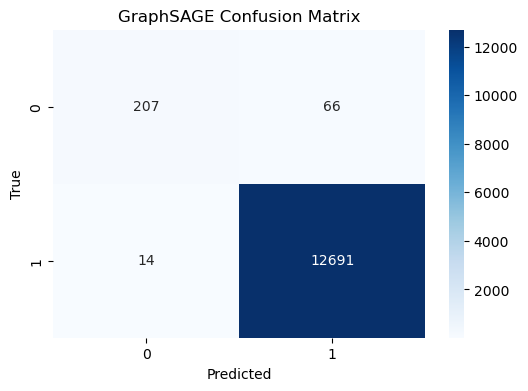

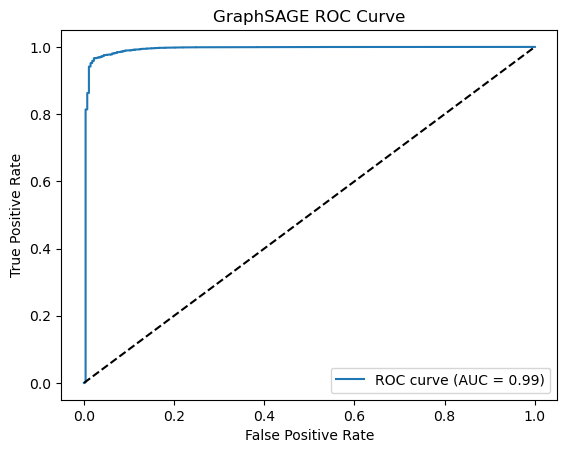


Training GCN...
GCN Epoch 10, Train Loss: 0.2404, Val Loss: 0.2909, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 20, Train Loss: 0.1250, Val Loss: 0.4646, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 30, Train Loss: 0.1012, Val Loss: 0.3604, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 40, Train Loss: 0.0944, Val Loss: 0.2663, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 50, Train Loss: 0.0889, Val Loss: 0.2852, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 60, Train Loss: 0.0883, Val Loss: 0.2847, Train Acc: 0.9781, Val Acc: 0.9793
GCN Epoch 70, Train Loss: 0.0865, Val Loss: 0.2936, Train Acc: 0.9786, Val Acc: 0.9798
GCN Epoch 80, Train Loss: 0.0845, Val Loss: 0.2816, Train Acc: 0.9788, Val Acc: 0.9803
GCN Epoch 90, Train Loss: 0.0800, Val Loss: 0.2988, Train Acc: 0.9793, Val Acc: 0.9809
GCN Epoch 100, Train Loss: 0.0794, Val Loss: 0.2738, Train Acc: 0.9797, Val Acc: 0.9809


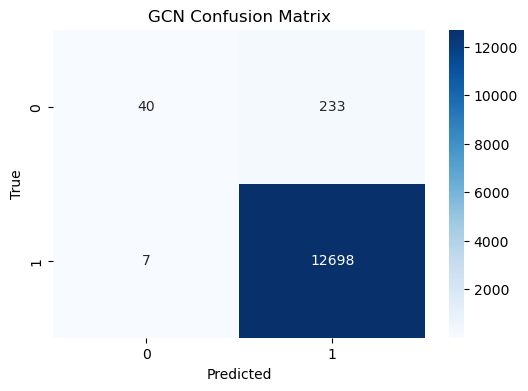

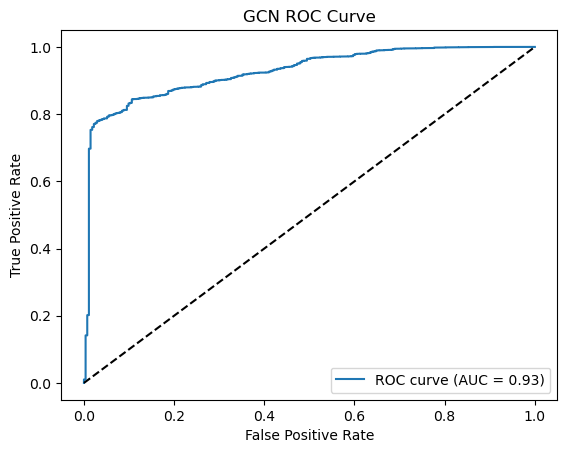


Training GAT...
GAT Epoch 10, Train Loss: 0.8109, Val Loss: 0.2530, Train Acc: 0.9673, Val Acc: 0.9790
GAT Epoch 20, Train Loss: 0.1437, Val Loss: 0.1183, Train Acc: 0.9777, Val Acc: 0.9790


In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv, GATConv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and sample dataset
df = pd.read_parquet("../dataset/NF_BoT_IoT_V2/NF-BoT-IoT-V2.parquet", engine="pyarrow")
df = df.sample(frac=0.01, random_state=42)
print(f"Sampled dataset shape: {df.shape}")

# Handle missing values
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(0)

# Encode categorical features
le_protocol = LabelEncoder()
df['PROTOCOL'] = le_protocol.fit_transform(df['PROTOCOL'].astype(str))
le_l7_proto = LabelEncoder()
df['L7_PROTO'] = le_l7_proto.fit_transform(df['L7_PROTO'].astype(str))

# Extract labels for binary classification
y = df['Label'].values

# Feature selection and normalization
feature_cols = [col for col in df.columns if col not in ['Label', 'Attack']]
X = df[feature_cols].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create preprocessed DataFrame
df_processed = pd.DataFrame(X, columns=feature_cols)
df_processed['Label'] = y
df_processed['L4_SRC_PORT'] = df['L4_SRC_PORT'].values
df_processed['L4_DST_PORT'] = df['L4_DST_PORT'].values
print(f"Preprocessed dataset shape: {df_processed.shape}")

# Graph construction
src_ports = df_processed['L4_SRC_PORT'].values
dst_ports = df_processed['L4_DST_PORT'].values
unique_ports = np.unique(np.concatenate([src_ports, dst_ports]))
port_to_idx = {port: idx for idx, port in enumerate(unique_ports)}

# Aggregate node features and labels
node_features = defaultdict(list)
node_labels = defaultdict(list)
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_port = row['L4_SRC_PORT']
    dst_port = row['L4_DST_PORT']
    features = row.drop(['Label', 'L4_SRC_PORT', 'L4_DST_PORT']).values
    label = row['Label']
    node_features[port_to_idx[src_port]].append(features[:-1])
    node_features[port_to_idx[dst_port]].append(features[:-1])
    node_labels[port_to_idx[src_port]].append(label)
    node_labels[port_to_idx[dst_port]].append(label)

# Compute average features and labels per node
x = []
y = []
for port_idx in range(len(unique_ports)):
    if port_idx in node_features:
        x.append(np.mean(node_features[port_idx], axis=0))
        y.append(np.mean(node_labels[port_idx]))
    else:
        x.append(np.zeros(df_processed.shape[1] - 3))
        y.append(0)

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Construct edges (bidirectional)
edge_index = []
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_idx = port_to_idx[row['L4_SRC_PORT']]
    dst_idx = port_to_idx[row['L4_DST_PORT']]
    edge_index.append([src_idx, dst_idx])
    edge_index.append([dst_idx, src_idx])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

# Create train/val/test masks (70% train, 10% val, 20% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.random.permutation(num_nodes)
train_size = int(0.7 * num_nodes)
val_size = int(0.1 * num_nodes)
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Model definitions
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(data.num_features, 32, heads=2)
        self.conv2 = GATConv(32 * 2, 64, heads=1)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(data.num_features, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 2)

    def forward(self, data):
        x = data.x
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Training and evaluation function
def train_and_evaluate(model, data, model_name, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Compute training metrics
        pred = out.argmax(dim=1)
        train_acc = accuracy_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy())
        train_losses.append(loss.item())
        train_accuracies.append(train_acc)

        # Compute validation metrics
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
            val_pred = out.argmax(dim=1)
            val_acc = accuracy_score(data.y[data.val_mask].numpy(), val_pred[data.val_mask].numpy())
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(f'{model_name} Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        y_true = data.y[data.test_mask].numpy()
        y_pred = pred[data.test_mask].numpy()
        y_score = out[data.test_mask][:, 1].numpy()

        # Compute metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        f1 = f1_score(y_true, y_pred, average='binary')

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'{model_name}_confusion_matrix.png')
        plt.show()
        plt.close()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend(loc='lower right')
        plt.savefig(f'{model_name}_roc_curve.png')
        plt.show()
        plt.close()

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc,
            'train_losses': train_losses, 'val_losses': val_losses, 'train_accuracies': train_accuracies, 'val_accuracies': val_accuracies}

# Train and evaluate all models
models = {
    'GraphSAGE': GraphSAGE(),
    'GCN': GCN(),
    'GAT': GAT(),
    'MLP': MLP()
}
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    results[name] = train_and_evaluate(model, data, name)

# Model comparison plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name in models:
    plt.plot(results[name]['train_accuracies'], label=f'{name} Train')
    plt.plot(results[name]['val_accuracies'], '--', label=f'{name} Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.subplot(1, 2, 2)
for name in models:
    plt.plot(results[name]['train_losses'], label=f'{name} Train')
    plt.plot(results[name]['val_losses'], '--', label=f'{name} Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()
plt.close()

# Print evaluation metrics
print("\nModel Comparison Metrics:")
for name in models:
    print(f"\n{name}:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1: {results[name]['f1']:.4f}")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")

Sampled dataset shape: (304201, 43)
Preprocessed dataset shape: (304201, 42)


C:\Users\gech\AppData\Local\Temp\ipykernel_7104\4243261245.py:82: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x = torch.tensor(x, dtype=torch.float)


Graph constructed: 64884 nodes, 608402 edges

Training GraphSAGE...
GraphSAGE Epoch 1, Train Loss: 0.6140, Val Loss: 0.4496, Train Acc: 0.9766, Val Acc: 0.9790
GraphSAGE Epoch 2, Train Loss: 0.4317, Val Loss: 0.2929, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 3, Train Loss: 0.2997, Val Loss: 0.1780, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 4, Train Loss: 0.1717, Val Loss: 0.1272, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 5, Train Loss: 0.1313, Val Loss: 0.1175, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 6, Train Loss: 0.1234, Val Loss: 0.1171, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 7, Train Loss: 0.1255, Val Loss: 0.1134, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 8, Train Loss: 0.1167, Val Loss: 0.1063, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 9, Train Loss: 0.1076, Val Loss: 0.0976, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 10, Train Loss: 0.0959, Val Loss: 0.0890, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE E

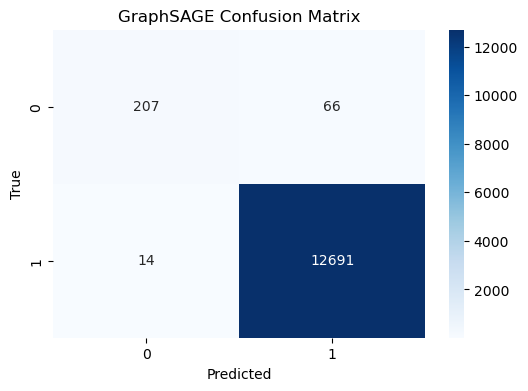

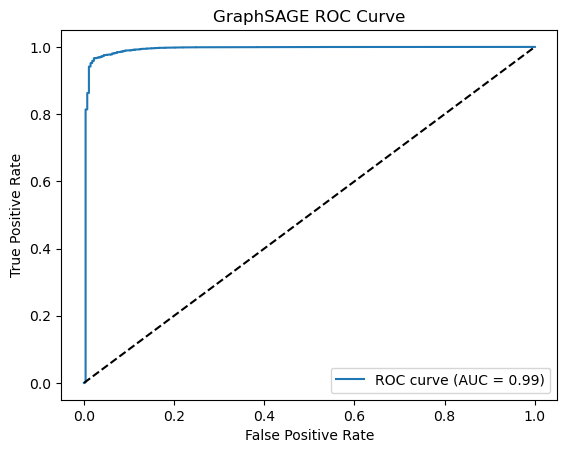


Training GCN...
GCN Epoch 1, Train Loss: 0.7432, Val Loss: 0.6982, Train Acc: 0.0224, Val Acc: 0.2546
GCN Epoch 2, Train Loss: 0.6972, Val Loss: 0.6561, Train Acc: 0.2117, Val Acc: 0.9790
GCN Epoch 3, Train Loss: 0.6488, Val Loss: 0.6076, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 4, Train Loss: 0.6056, Val Loss: 0.5522, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 5, Train Loss: 0.5414, Val Loss: 0.4930, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 6, Train Loss: 0.4744, Val Loss: 0.4337, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 7, Train Loss: 0.3965, Val Loss: 0.3790, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 8, Train Loss: 0.3400, Val Loss: 0.3345, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 9, Train Loss: 0.2766, Val Loss: 0.3043, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 10, Train Loss: 0.2404, Val Loss: 0.2909, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 11, Train Loss: 0.1973, Val Loss: 0.2943, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 12, Train Loss: 0.1534, V

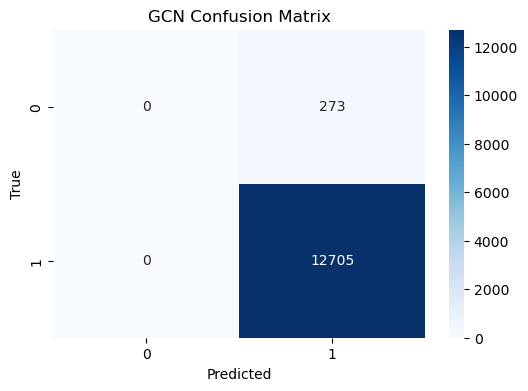

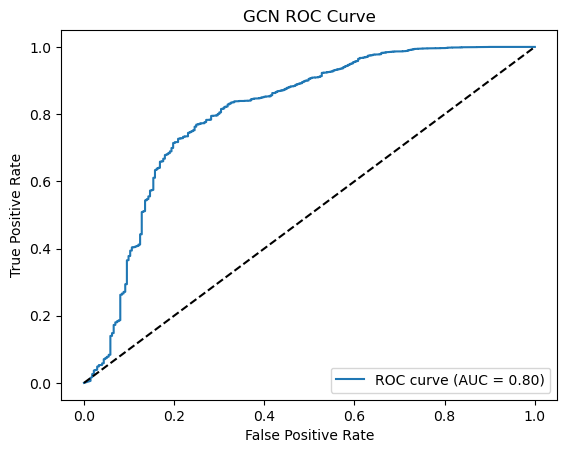


Training GAT...
GAT Epoch 1, Train Loss: 9.8858, Val Loss: 0.3677, Train Acc: 0.0230, Val Acc: 0.9790
GAT Epoch 2, Train Loss: 0.3622, Val Loss: 0.5424, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 3, Train Loss: 0.1324, Val Loss: 0.7181, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 4, Train Loss: 0.2168, Val Loss: 0.8961, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 5, Train Loss: 1.4227, Val Loss: 0.8545, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 6, Train Loss: 0.7485, Val Loss: 0.8863, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 7, Train Loss: 0.7784, Val Loss: 0.8760, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 8, Train Loss: 0.4726, Val Loss: 0.8613, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 9, Train Loss: 1.3161, Val Loss: 0.8178, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 10, Train Loss: 1.5281, Val Loss: 0.7337, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 11, Train Loss: 1.0577, Val Loss: 0.6165, Train Acc: 0.9777, Val Acc: 0.9790
GAT Early stopping at epoch 11


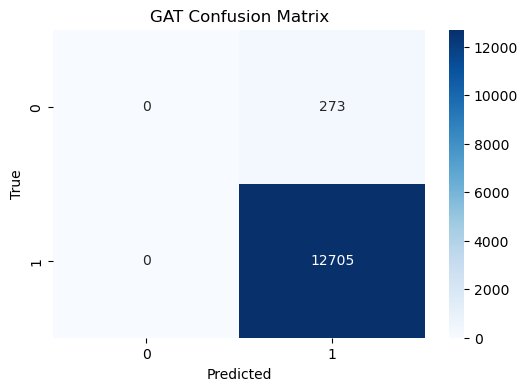

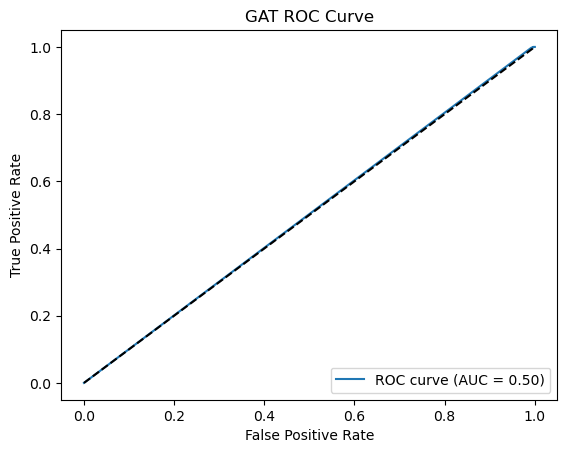


Training MLP...
MLP Epoch 1, Train Loss: 0.7307, Val Loss: 0.6001, Train Acc: 0.0897, Val Acc: 0.9790
MLP Epoch 2, Train Loss: 0.5948, Val Loss: 0.4638, Train Acc: 0.9776, Val Acc: 0.9790
MLP Epoch 3, Train Loss: 0.4601, Val Loss: 0.3252, Train Acc: 0.9777, Val Acc: 0.9790
MLP Epoch 4, Train Loss: 0.3275, Val Loss: 0.2099, Train Acc: 0.9777, Val Acc: 0.9790
MLP Epoch 5, Train Loss: 0.2191, Val Loss: 0.1407, Train Acc: 0.9777, Val Acc: 0.9790
MLP Epoch 6, Train Loss: 0.1552, Val Loss: 0.1128, Train Acc: 0.9777, Val Acc: 0.9790
MLP Epoch 7, Train Loss: 0.1248, Val Loss: 0.1026, Train Acc: 0.9777, Val Acc: 0.9790
MLP Epoch 8, Train Loss: 0.1143, Val Loss: 0.0957, Train Acc: 0.9777, Val Acc: 0.9790
MLP Epoch 9, Train Loss: 0.1074, Val Loss: 0.0889, Train Acc: 0.9777, Val Acc: 0.9790
MLP Epoch 10, Train Loss: 0.1000, Val Loss: 0.0826, Train Acc: 0.9777, Val Acc: 0.9790
MLP Epoch 11, Train Loss: 0.0899, Val Loss: 0.0775, Train Acc: 0.9777, Val Acc: 0.9790
MLP Epoch 12, Train Loss: 0.0827, V

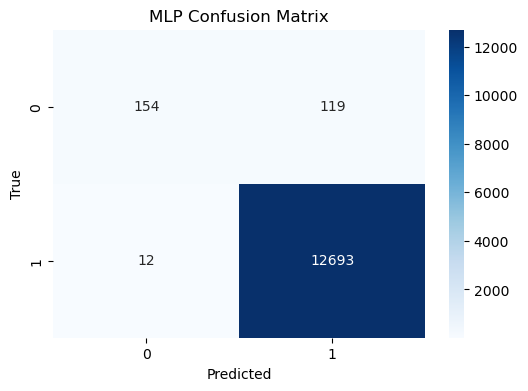

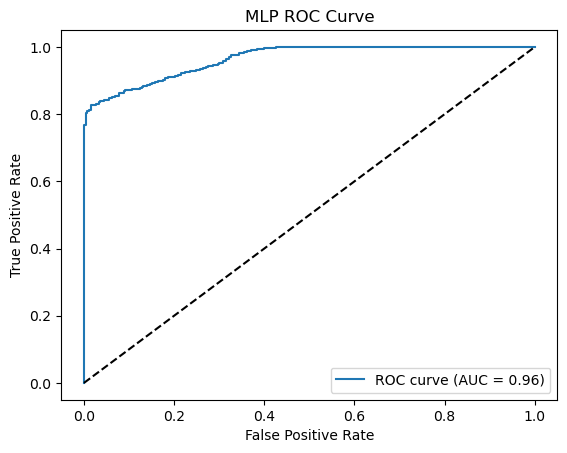

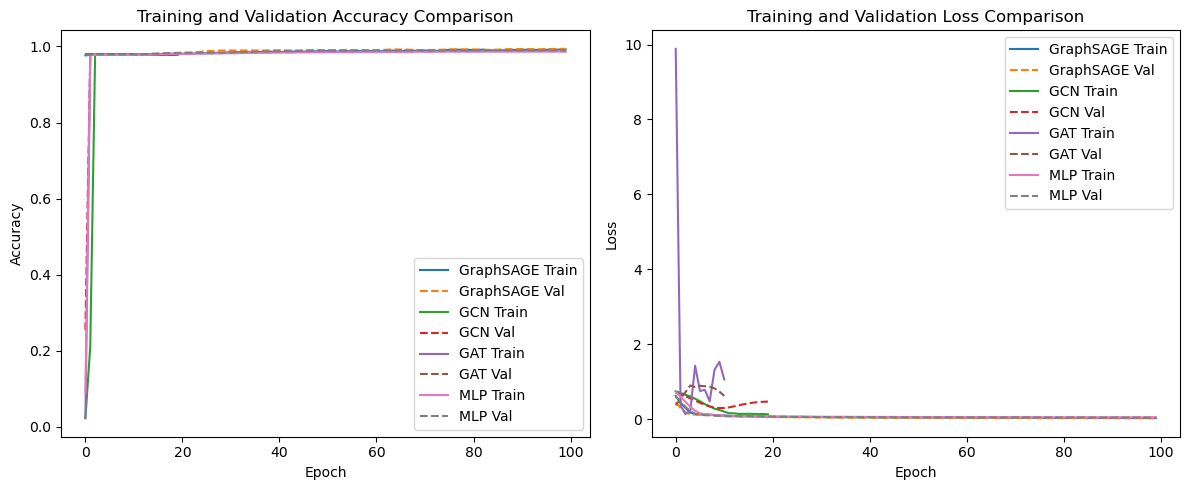


Model Comparison Metrics:

GraphSAGE:
Accuracy: 0.9938
Precision: 0.9948
Recall: 0.9989
F1: 0.9969
ROC AUC: 0.9922

GCN:
Accuracy: 0.9790
Precision: 0.9790
Recall: 1.0000
F1: 0.9894
ROC AUC: 0.8049

GAT:
Accuracy: 0.9790
Precision: 0.9790
Recall: 1.0000
F1: 0.9894
ROC AUC: 0.5027

MLP:
Accuracy: 0.9899
Precision: 0.9907
Recall: 0.9991
F1: 0.9949
ROC AUC: 0.9639


In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv, GATConv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and sample dataset
df = pd.read_parquet("../dataset/NF_BoT_IoT_V2/NF-BoT-IoT-V2.parquet", engine="pyarrow")
df = df.sample(frac=0.01, random_state=42)
print(f"Sampled dataset shape: {df.shape}")

# Handle missing values
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(0)

# Encode categorical features
le_protocol = LabelEncoder()
df['PROTOCOL'] = le_protocol.fit_transform(df['PROTOCOL'].astype(str))
le_l7_proto = LabelEncoder()
df['L7_PROTO'] = le_l7_proto.fit_transform(df['L7_PROTO'].astype(str))

# Extract labels for binary classification
y = df['Label'].values

# Feature selection and normalization
feature_cols = [col for col in df.columns if col not in ['Label', 'Attack']]
X = df[feature_cols].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create preprocessed DataFrame
df_processed = pd.DataFrame(X, columns=feature_cols)
df_processed['Label'] = y
df_processed['L4_SRC_PORT'] = df['L4_SRC_PORT'].values
df_processed['L4_DST_PORT'] = df['L4_DST_PORT'].values
print(f"Preprocessed dataset shape: {df_processed.shape}")

# Graph construction
src_ports = df_processed['L4_SRC_PORT'].values
dst_ports = df_processed['L4_DST_PORT'].values
unique_ports = np.unique(np.concatenate([src_ports, dst_ports]))
port_to_idx = {port: idx for idx, port in enumerate(unique_ports)}

# Aggregate node features and labels
node_features = defaultdict(list)
node_labels = defaultdict(list)
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_port = row['L4_SRC_PORT']
    dst_port = row['L4_DST_PORT']
    features = row.drop(['Label', 'L4_SRC_PORT', 'L4_DST_PORT']).values
    label = row['Label']
    node_features[port_to_idx[src_port]].append(features[:-1])
    node_features[port_to_idx[dst_port]].append(features[:-1])
    node_labels[port_to_idx[src_port]].append(label)
    node_labels[port_to_idx[dst_port]].append(label)

# Compute average features and labels per node
x = []
y = []
for port_idx in range(len(unique_ports)):
    if port_idx in node_features:
        x.append(np.mean(node_features[port_idx], axis=0))
        y.append(np.mean(node_labels[port_idx]))
    else:
        x.append(np.zeros(df_processed.shape[1] - 3))
        y.append(0)

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Construct edges (bidirectional)
edge_index = []
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_idx = port_to_idx[row['L4_SRC_PORT']]
    dst_idx = port_to_idx[row['L4_DST_PORT']]
    edge_index.append([src_idx, dst_idx])
    edge_index.append([dst_idx, src_idx])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

# Create train/val/test masks (70% train, 10% val, 20% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.random.permutation(num_nodes)
train_size = int(0.7 * num_nodes)
val_size = int(0.1 * num_nodes)
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Model definitions
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(data.num_features, 32, heads=2)
        self.conv2 = GATConv(32 * 2, 64, heads=1)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(data.num_features, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 2)

    def forward(self, data):
        x = data.x
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Training and evaluation function with early stopping
def train_and_evaluate(model, data, model_name, max_epochs=100, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Compute training metrics
        pred = out.argmax(dim=1)
        train_acc = accuracy_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy())
        train_losses.append(loss.item())
        train_accuracies.append(train_acc)

        # Compute validation metrics
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
            val_pred = out.argmax(dim=1)
            val_acc = accuracy_score(data.y[data.val_mask].numpy(), val_pred[data.val_mask].numpy())
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)

        # Print metrics for every epoch
        print(f'{model_name} Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'{model_name} Early stopping at epoch {epoch + 1}')
                break

    # Load best model for evaluation
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        y_true = data.y[data.test_mask].numpy()
        y_pred = pred[data.test_mask].numpy()
        y_score = out[data.test_mask][:, 1].numpy()

        # Compute metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        f1 = f1_score(y_true, y_pred, average='binary')

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'{model_name}_confusion_matrix.png')
        plt.show()
        plt.close()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend(loc='lower right')
        plt.savefig(f'{model_name}_roc_curve.png')
        plt.show()
        plt.close()

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc,
            'train_losses': train_losses, 'val_losses': val_losses, 'train_accuracies': train_accuracies, 'val_accuracies': val_accuracies}

# Train and evaluate all models
models = {
    'GraphSAGE': GraphSAGE(),
    'GCN': GCN(),
    'GAT': GAT(),
    'MLP': MLP()
}
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    results[name] = train_and_evaluate(model, data, name)

# Model comparison plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name in models:
    plt.plot(results[name]['train_accuracies'], label=f'{name} Train')
    plt.plot(results[name]['val_accuracies'], '--', label=f'{name} Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.subplot(1, 2, 2)
for name in models:
    plt.plot(results[name]['train_losses'], label=f'{name} Train')
    plt.plot(results[name]['val_losses'], '--', label=f'{name} Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()
plt.close()

# Print evaluation metrics
print("\nModel Comparison Metrics:")
for name in models:
    print(f"\n{name}:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1: {results[name]['f1']:.4f}")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")

Sampled dataset shape: (304201, 43)
Preprocessed dataset shape: (304201, 42)
Graph constructed: 64884 nodes, 608402 edges


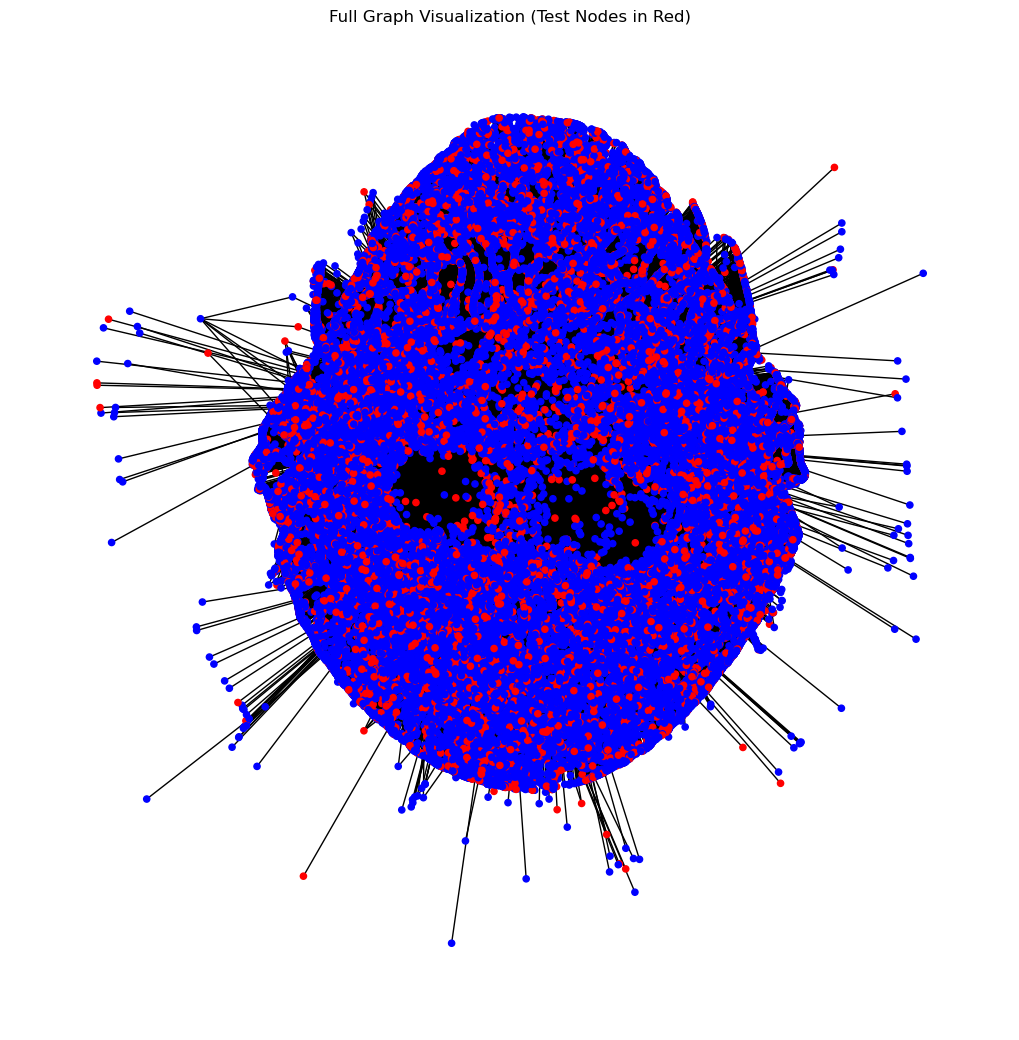

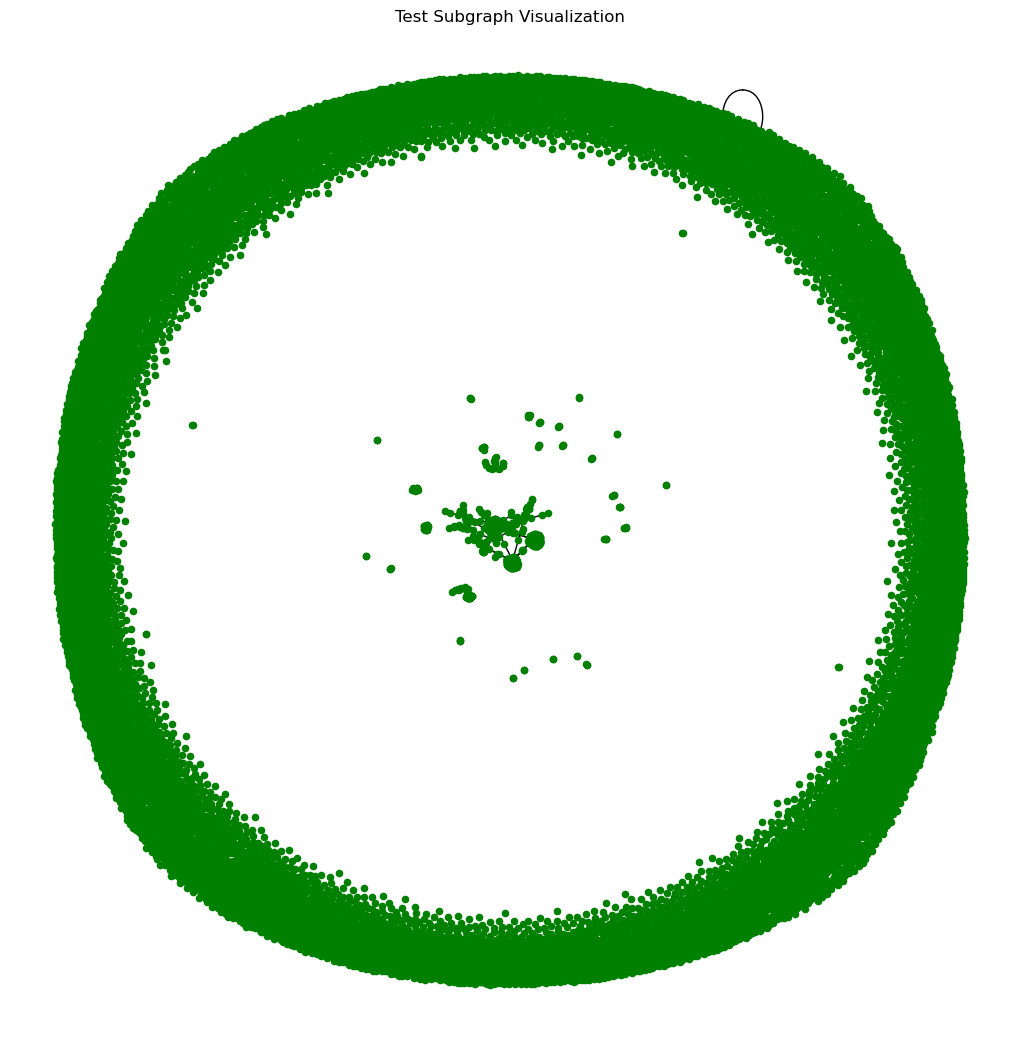


Training GraphSAGE...
GraphSAGE Epoch 1, Train Loss: 0.6090, Val Loss: 0.4536, Train Acc: 0.9771, Val Acc: 0.9790
GraphSAGE Epoch 2, Train Loss: 0.4377, Val Loss: 0.2930, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 3, Train Loss: 0.3033, Val Loss: 0.1776, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 4, Train Loss: 0.1691, Val Loss: 0.1263, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 5, Train Loss: 0.1319, Val Loss: 0.1171, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 6, Train Loss: 0.1264, Val Loss: 0.1161, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 7, Train Loss: 0.1263, Val Loss: 0.1115, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 8, Train Loss: 0.1133, Val Loss: 0.1033, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 9, Train Loss: 0.1139, Val Loss: 0.0933, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 10, Train Loss: 0.1055, Val Loss: 0.0835, Train Acc: 0.9777, Val Acc: 0.9790
GraphSAGE Epoch 11, Train Loss: 0.0815, Val Loss: 0.0762

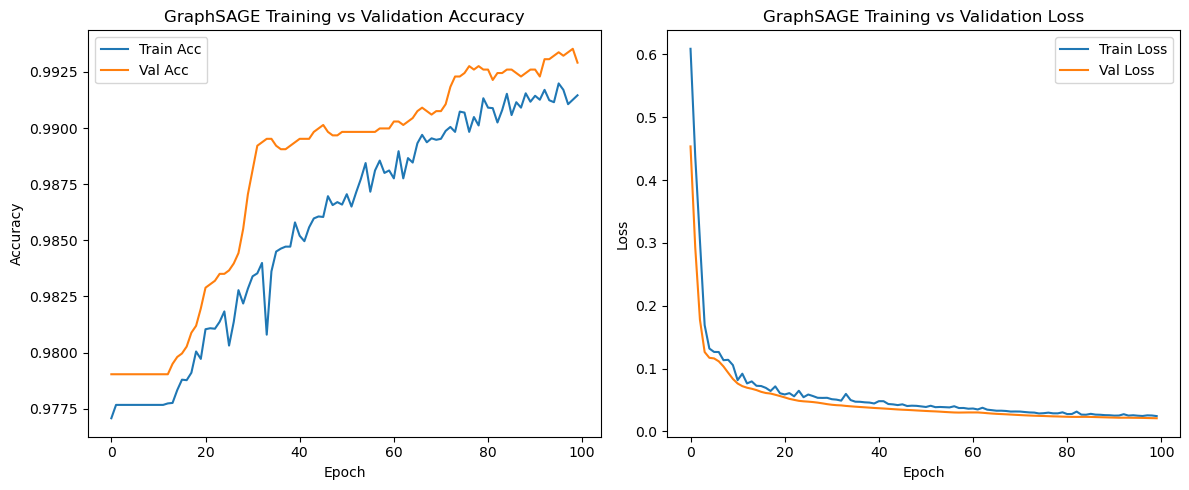

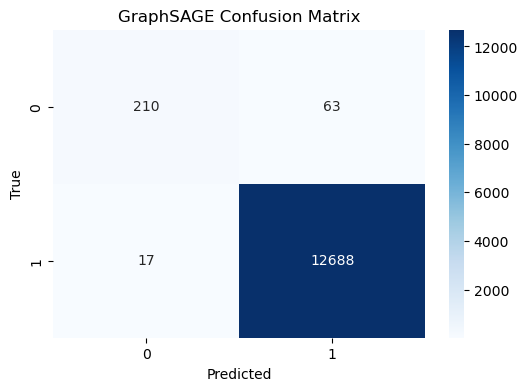

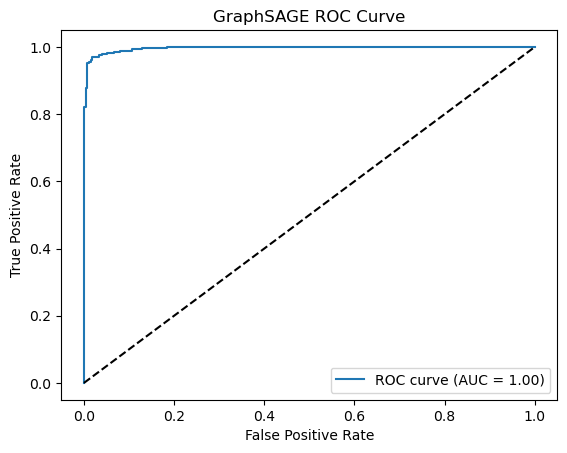


Training GCN...
GCN Epoch 1, Train Loss: 0.7441, Val Loss: 0.6988, Train Acc: 0.0224, Val Acc: 0.2497
GCN Epoch 2, Train Loss: 0.6997, Val Loss: 0.6567, Train Acc: 0.1961, Val Acc: 0.9790
GCN Epoch 3, Train Loss: 0.6528, Val Loss: 0.6085, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 4, Train Loss: 0.5956, Val Loss: 0.5535, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 5, Train Loss: 0.5404, Val Loss: 0.4950, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 6, Train Loss: 0.4805, Val Loss: 0.4369, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 7, Train Loss: 0.3924, Val Loss: 0.3838, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 8, Train Loss: 0.3280, Val Loss: 0.3405, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 9, Train Loss: 0.2780, Val Loss: 0.3113, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 10, Train Loss: 0.2109, Val Loss: 0.2980, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 11, Train Loss: 0.1844, Val Loss: 0.3002, Train Acc: 0.9777, Val Acc: 0.9790
GCN Epoch 12, Train Loss: 0.1723, V

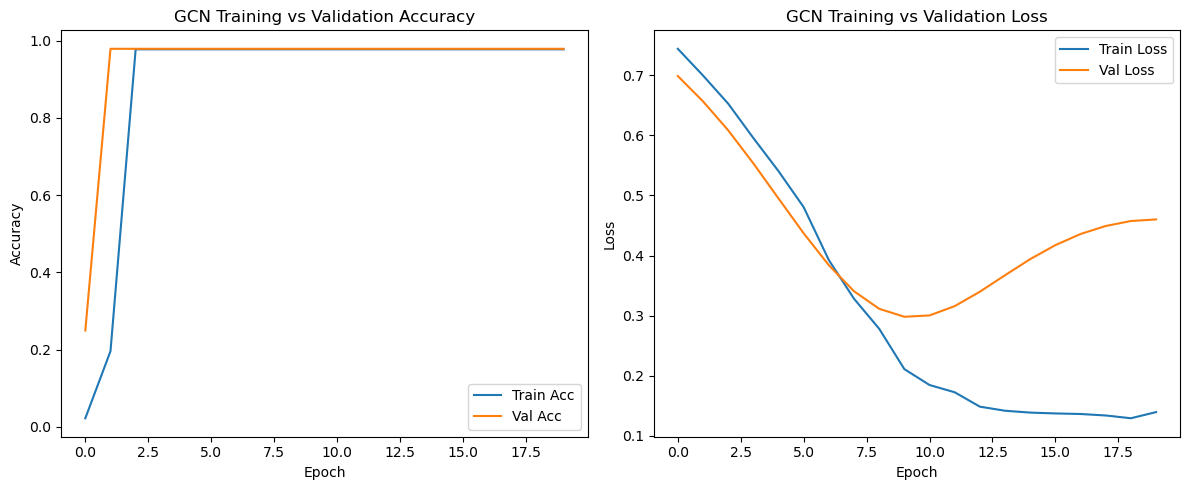

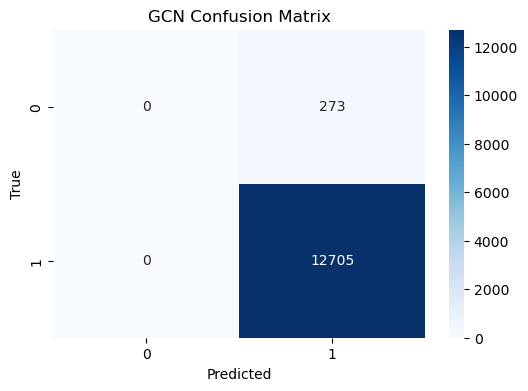

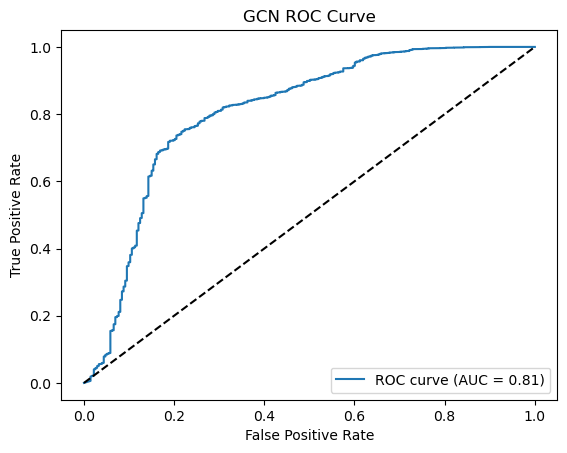


Training GAT...
GAT Epoch 1, Train Loss: 0.1249, Val Loss: 0.3030, Train Acc: 0.9761, Val Acc: 0.9790
GAT Epoch 2, Train Loss: 0.4083, Val Loss: 0.3711, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 3, Train Loss: 0.2804, Val Loss: 0.3249, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 4, Train Loss: 0.6432, Val Loss: 0.1229, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 5, Train Loss: 0.1595, Val Loss: 0.1384, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 6, Train Loss: 0.1209, Val Loss: 0.1815, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 7, Train Loss: 0.1281, Val Loss: 0.2599, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 8, Train Loss: 0.1746, Val Loss: 0.1846, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 9, Train Loss: 0.1863, Val Loss: 0.1190, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 10, Train Loss: 0.1122, Val Loss: 0.1029, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 11, Train Loss: 0.1458, Val Loss: 0.1131, Train Acc: 0.9777, Val Acc: 0.9790
GAT Epoch 12, Train Loss: 0.2848, V

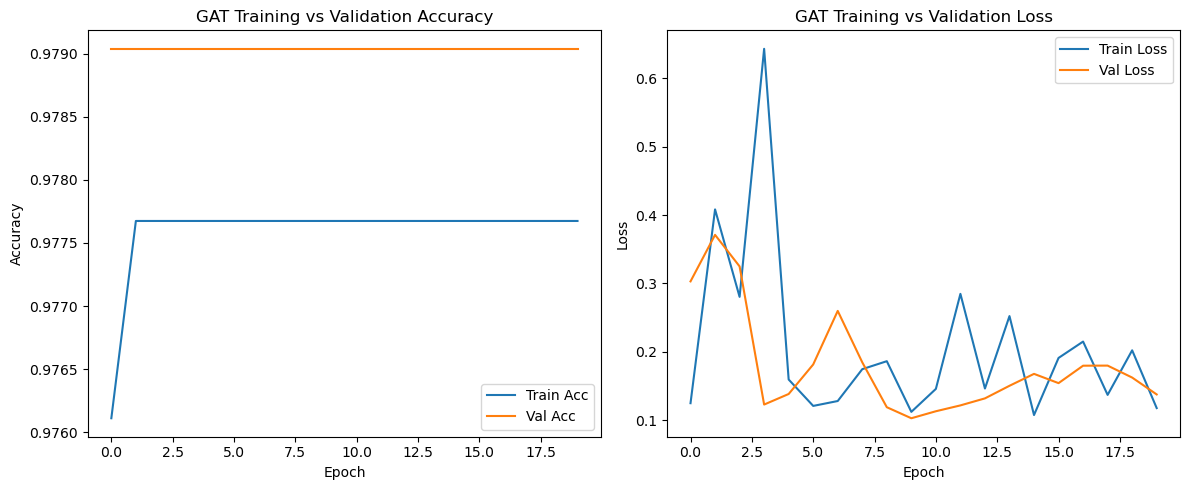

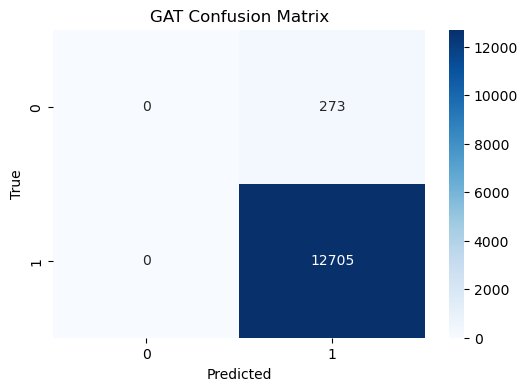

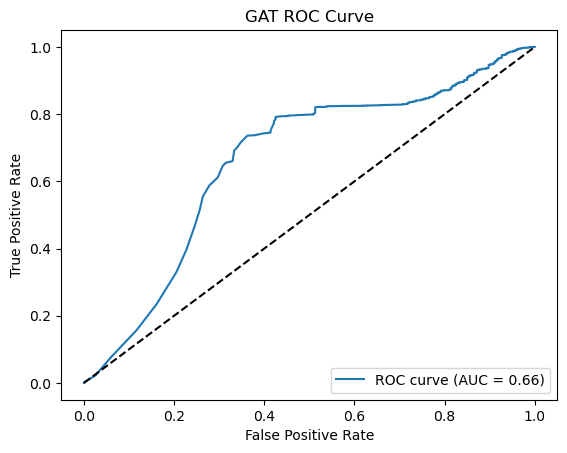


Training GraphTransformer...
GraphTransformer Epoch 1, Train Loss: 0.8143, Val Loss: 0.5216, Train Acc: 0.0444, Val Acc: 0.9790
GraphTransformer Epoch 2, Train Loss: 0.5282, Val Loss: 0.3314, Train Acc: 0.9777, Val Acc: 0.9790
GraphTransformer Epoch 3, Train Loss: 0.3272, Val Loss: 0.1975, Train Acc: 0.9777, Val Acc: 0.9790
GraphTransformer Epoch 4, Train Loss: 0.2181, Val Loss: 0.1305, Train Acc: 0.9777, Val Acc: 0.9790
GraphTransformer Epoch 5, Train Loss: 0.1445, Val Loss: 0.1130, Train Acc: 0.9777, Val Acc: 0.9790
GraphTransformer Epoch 6, Train Loss: 0.1196, Val Loss: 0.1129, Train Acc: 0.9777, Val Acc: 0.9790
GraphTransformer Epoch 7, Train Loss: 0.1178, Val Loss: 0.1137, Train Acc: 0.9777, Val Acc: 0.9790
GraphTransformer Epoch 8, Train Loss: 0.1233, Val Loss: 0.1121, Train Acc: 0.9777, Val Acc: 0.9790
GraphTransformer Epoch 9, Train Loss: 0.1258, Val Loss: 0.1096, Train Acc: 0.9777, Val Acc: 0.9790
GraphTransformer Epoch 10, Train Loss: 0.1201, Val Loss: 0.1061, Train Acc: 0.9

: 

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, TransformerConv
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and sample dataset
df = pd.read_parquet("../dataset/NF_BoT_IoT_V2/NF-BoT-IoT-V2.parquet", engine="pyarrow")
df = df.sample(frac=0.01, random_state=42)
print(f"Sampled dataset shape: {df.shape}")

# Handle missing values
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(0)

# Encode categorical features
le_protocol = LabelEncoder()
df['PROTOCOL'] = le_protocol.fit_transform(df['PROTOCOL'].astype(str))
le_l7_proto = LabelEncoder()
df['L7_PROTO'] = le_l7_proto.fit_transform(df['L7_PROTO'].astype(str))

# Extract labels for binary classification
y = df['Label'].values

# Feature selection and normalization
feature_cols = [col for col in df.columns if col not in ['Label', 'Attack']]
X = df[feature_cols].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create preprocessed DataFrame
df_processed = pd.DataFrame(X, columns=feature_cols)
df_processed['Label'] = y
df_processed['L4_SRC_PORT'] = df['L4_SRC_PORT'].values
df_processed['L4_DST_PORT'] = df['L4_DST_PORT'].values
print(f"Preprocessed dataset shape: {df_processed.shape}")

# Graph construction
src_ports = df_processed['L4_SRC_PORT'].values
dst_ports = df_processed['L4_DST_PORT'].values
unique_ports = np.unique(np.concatenate([src_ports, dst_ports]))
port_to_idx = {port: idx for idx, port in enumerate(unique_ports)}

# Aggregate node features and labels
node_features = defaultdict(list)
node_labels = defaultdict(list)
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_port = row['L4_SRC_PORT']
    dst_port = row['L4_DST_PORT']
    features = row.drop(['Label', 'L4_SRC_PORT', 'L4_DST_PORT']).values
    label = row['Label']
    node_features[port_to_idx[src_port]].append(features[:-1])
    node_features[port_to_idx[dst_port]].append(features[:-1])
    node_labels[port_to_idx[src_port]].append(label)
    node_labels[port_to_idx[dst_port]].append(label)

# Compute average features and labels per node
x = []
y = []
for port_idx in range(len(unique_ports)):
    if port_idx in node_features:
        x.append(np.mean(node_features[port_idx], axis=0))
        y.append(np.mean(node_labels[port_idx]))
    else:
        x.append(np.zeros(df_processed.shape[1] - 3))
        y.append(0)

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Construct edges (bidirectional)
edge_index = []
for idx in range(len(df_processed)):
    row = df_processed.iloc[idx]
    src_idx = port_to_idx[row['L4_SRC_PORT']]
    dst_idx = port_to_idx[row['L4_DST_PORT']]
    edge_index.append([src_idx, dst_idx])
    edge_index.append([dst_idx, src_idx])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Graph constructed: {data.num_nodes} nodes, {data.num_edges} edges")

# Visualize full graph with test nodes highlighted (after masks are created)

# Create train/val/test masks (70% train, 10% val, 20% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.random.permutation(num_nodes)
train_size = int(0.7 * num_nodes)
val_size = int(0.1 * num_nodes)
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Graph visualization - Full graph
G = to_networkx(data, to_undirected=True)
node_colors = ['red' if test_mask[i] else 'blue' for i in range(num_nodes)]
plt.figure(figsize=(10, 10))
nx.draw(G, node_color=node_colors, node_size=20, with_labels=False)
plt.title('Full Graph Visualization (Test Nodes in Red)')
plt.savefig('full_graph_visualization.png')
plt.show()
plt.close()

# Graph visualization - Test subgraph
test_indices = torch.where(test_mask)[0]
test_subgraph = data.subgraph(test_indices)
G_test = to_networkx(test_subgraph, to_undirected=True)
plt.figure(figsize=(10, 10))
nx.draw(G_test, node_color='green', node_size=20, with_labels=False)
plt.title('Test Subgraph Visualization')
plt.savefig('test_subgraph_visualization.png')
plt.show()
plt.close()

# Model definitions
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(data.num_features, 64)
        self.conv2 = SAGEConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(data.num_features, 32, heads=2)
        self.conv2 = GATConv(32 * 2, 64, heads=1)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class GraphTransformer(torch.nn.Module):
    def __init__(self):
        super(GraphTransformer, self).__init__()
        self.conv1 = TransformerConv(data.num_features, 64)
        self.conv2 = TransformerConv(64, 64)
        self.fc = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(data.num_features, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 2)

    def forward(self, data):
        x = data.x
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Training and evaluation function with early stopping
def train_and_evaluate(model, data, model_name, max_epochs=100, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Compute training metrics
        pred = out.argmax(dim=1)
        train_acc = accuracy_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy())
        train_losses.append(loss.item())
        train_accuracies.append(train_acc)

        # Compute validation metrics
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
            val_pred = out.argmax(dim=1)
            val_acc = accuracy_score(data.y[data.val_mask].numpy(), val_pred[data.val_mask].numpy())
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)

        # Print metrics for every epoch
        print(f'{model_name} Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'{model_name} Early stopping at epoch {epoch + 1}')
                break

    # Load best model for evaluation
    model.load_state_dict(best_model_state)

    # Plot training vs validation accuracy and loss for this model
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Training vs Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{model_name}_acc_loss.png')
    plt.show()
    plt.close()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        y_true = data.y[data.test_mask].numpy()
        y_pred = pred[data.test_mask].numpy()
        y_score = out[data.test_mask][:, 1].numpy()

        # Compute metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        f1 = f1_score(y_true, y_pred, average='binary')

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'{model_name}_confusion_matrix.png')
        plt.show()
        plt.close()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend(loc='lower right')
        plt.savefig(f'{model_name}_roc_curve.png')
        plt.show()
        plt.close()

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc,
            'train_losses': train_losses, 'val_losses': val_losses, 'train_accuracies': train_accuracies, 'val_accuracies': val_accuracies}

# Train and evaluate all models
models = {
    'GraphSAGE': GraphSAGE(),
    'GCN': GCN(),
    'GAT': GAT(),
    'GraphTransformer': GraphTransformer(),
    'MLP': MLP()
}
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    results[name] = train_and_evaluate(model, data, name)

# Model comparison plots (combined)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name in models:
    plt.plot(results[name]['train_accuracies'], label=f'{name} Train')
    plt.plot(results[name]['val_accuracies'], '--', label=f'{name} Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.subplot(1, 2, 2)
for name in models:
    plt.plot(results[name]['train_losses'], label=f'{name} Train')
    plt.plot(results[name]['val_losses'], '--', label=f'{name} Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()
plt.close()

# Print evaluation metrics
print("\nModel Comparison Metrics:")
for name in models:
    print(f"\n{name}:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1: {results[name]['f1']:.4f}")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")